In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)
cuda = torch.device('cuda')
b1 = torch.tensor([1., 2.]).to(device=cuda)

NVIDIA RTX A6000


In [2]:
model_name_or_path = 'meta-llama/Llama-2-7b-chat-hf'

print('Loading model...')
#load the model in 16 bit precision
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map="auto", cache_dir='/scratch/henrypapadatos', torch_dtype=torch.float16)

print(model.device)

print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, cache_dir='/scratch/henrypapadatos', padding_side="left")
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.unk_token

Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
from datasets import load_dataset
import pandas as pd
dataset = load_dataset("rotten_tomatoes")
#convert to dataframe
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_val = pd.DataFrame(dataset['validation'])
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

df_train.head()

(8530, 2)
(1066, 2)
(1066, 2)


,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [4]:
template = '''[INST] Do you think that "{comment}” is negative or positive sentiment?

Choices:
(A) Negative
(B) Positive

[/INST] I believe the best answer is: ('''

#note: in the rotten tomatoes dataset, 1 is positive and 0 is negative
#in our template, B is positive and A is negative
Labels = ['A', 'B']

A_index = tokenizer.convert_tokens_to_ids('A')
B_index = tokenizer.convert_tokens_to_ids('B')

In [ ]:
def filtration(df):

    batch_size = 64
    num_batches = len(df) // batch_size + 1

    for batch_idx in tqdm(range(num_batches)):

        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]

        prompts = [template.format(comment=row['text']) for _, row in batch_df.iterrows()]
        tokens = tokenizer.batch_encode_plus(prompts, return_tensors='pt', padding=True, truncation=False).to(device=cuda)

        with torch.no_grad():
            # print('tokens: ', tokens['input_ids'])
            # print('attention mask: ', tokens['attention_mask'])
            output = model(tokens['input_ids'], attention_mask=tokens['attention_mask'])
            
            logits = output.logits

            for i in range(logits.shape[0]):
                #get the logits for the last token
                current_logits = logits[i, -1, :]
                #get the most likely token
                most_likely_token_index = torch.argmax(current_logits).item()
                most_likely = tokenizer.convert_ids_to_tokens([most_likely_token_index])[0] 

                # print('text: ', batch_df.iloc[i]['text'])
                # print('label: ', batch_df.iloc[i]['label'])
                # print('most likely: ', most_likely)

                # if most_likely != 'A' and most_likely != 'B':
                #     print('Unexpected token: ', most_likely)
                #     print('prompt: ', batch_df.iloc[i]['text'])

                #if the most likely token corresponds to the correct label
                if most_likely == Labels[batch_df.iloc[i]['label']]:

                    # print('correct')
                    A_B_logits = current_logits[[A_index, B_index]]                
                    A_B_logits = torch.softmax(A_B_logits, dim=0)
                    certainty = A_B_logits[batch_df.iloc[i]['label']].item()
                    df.loc[start_idx+i,'correct'] = certainty

                else: 
                    # print('incorrect: ', most_likely_token_index)
                    # print('prompt: ', prompts[i])
                    df.loc[start_idx+i,'correct'] = 0

                # if i==batch_size-1:
                #     print("COMPLETE OUTPUT ##############################################################################################")
                #     answers = model.generate(tokens['input_ids'], attention_mask=tokens['attention_mask'], max_length=200, do_sample=False)
                #     decoded_answers = tokenizer.batch_decode(answers, skip_special_tokens=False)
                #     for index, el in enumerate(decoded_answers):
                #         print(el)
                            
                #     raise Exception('stop')
            
            #release memory
        torch.cuda.empty_cache()



<Axes: >

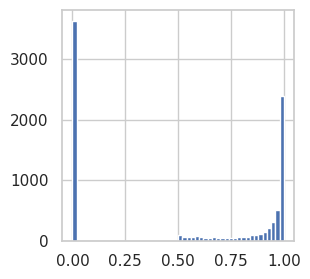

In [21]:
df_train['correct'] = np.nan
filtration(df_train)
#get the distribution of the certainty scores
df_train['correct'].hist(bins=50, figsize=(3,3))

100%|██████████| 267/267 [00:22<00:00, 12.06it/s]


<Axes: >

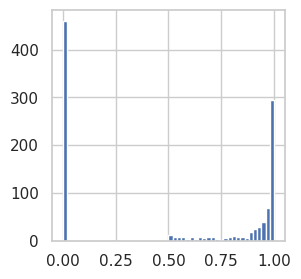

In [20]:
df_test['correct'] = np.nan
filtration(df_test)
#get the distribution of the certainty scores
df_test['correct'].hist(bins=50, figsize=(3,3))

100%|██████████| 267/267 [00:22<00:00, 12.05it/s]


<Axes: >

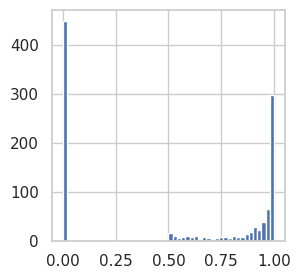

In [22]:
df_val['correct'] = np.nan
filtration(df_val) 
#get the distribution of the certainty scores
df_val['correct'].hist(bins=50, figsize=(3,3))

In [23]:
#print the percentage of correct answers
print("percentage of correct answers")
print((df_train['correct'] > 0.5).sum() / len(df_train))
print((df_test['correct'] > 0.5).sum() / len(df_test))
print((df_val['correct'] > 0.5).sum() / len(df_val))

#print the percentage of correct == 0 answers
print("percentage of uncorrect answers")
print((df_train['correct'] == 0).sum() / len(df_train))
print((df_test['correct'] == 0).sum() / len(df_test))
print((df_val['correct'] == 0).sum() / len(df_val))

percentage of correct answers
0.5715123094958968
0.5656660412757973
0.575046904315197
percentage of uncorrect answers
0.42626025791324734
0.43151969981238275
0.42213883677298314


[0.15099648300117233, 0.13696060037523453, 0.15572232645403378]
[0.9964830011723329, 1.0, 1.0]


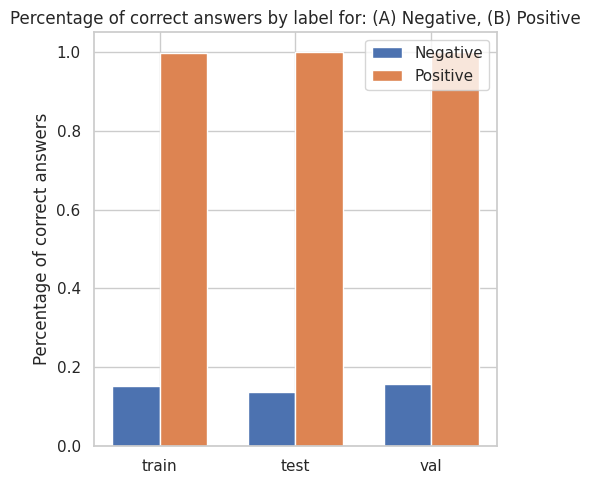

In [34]:
#count the percentage of correct > 0.0 for both labels==1 and labels==0 and do a bar plot for all the df
df_array = [df_train, df_test, df_val]
correct_label_0 = [df [df['label']==0]['correct'].apply(lambda x: x>0.0).mean() for df in df_array]
print(correct_label_0)
correct_label_1 = [df [df['label']==1]['correct'].apply(lambda x: x>0.0).mean() for df in df_array]
print(correct_label_1)



labels = ['train', 'test', 'val']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(5,5))
rects1 = ax.bar(x - width/2, correct_label_0, width, label='Negative')
rects2 = ax.bar(x + width/2, correct_label_1, width, label='Positive')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of correct answers')
ax.set_title('Percentage of correct answers by label for: (A) Negative, (B) Positive')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [36]:
#save to csv
df_train.to_csv('datasets/rotten_tomato_llama_2_7b_train_(A)Negative_(B)Positive.csv')
df_test.to_csv('datasets/rotten_tomato_llama_2_7b_test_(A)Negative_(B)Positive.csv')
df_val.to_csv('datasets/rotten_tomato_llama_2_7b_val_(A)Negative_(B)Positive.csv')